<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

 # Module 2a

# *Online Dermatologists:* 📱 🌐 Diagnosing Skin Cancer through a Web Application 

In this project, we will be be diagnosing skin lesion images for signs of skin cancer. To perform this task, we'll be working with an array of machine learning methods and models.

We're hoping that our model might be useful to people who don't have easy access to medical professionals. For that, it'll need to be both highly accurate and easily accessible! Yesterday's simple models didn't perform well enough for this job.

In this notebook we'll be:
*   Developing more complex ML models using Convolutional Neural Networks
*   Deploying our ML models to a web app

# Set up our Environment

In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
print("Installing packages...")
!pip install hypopt tensorflowjs > /dev/null
print("Downloading files...")
!wget https://www.dropbox.com/s/fedqcdt4o0m2oxp/X.npy &> /dev/null
!wget https://www.dropbox.com/s/h7xh92w1w7px30a/X_g.npy &> /dev/null
!wget https://www.dropbox.com/s/grn9brfvzx74c8a/y.npy &> /dev/null
print("Importing stuff...")
import os
os.makedirs("static/js", exist_ok=True)
!wget -O static/js/skin_cancer_diagnosis_script.js 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20B)%20Skin%20Cancer%20Diagnosis/skin_cancer_diagnosis_script.js' &> /dev/null
output = 'static/js/skin_cancer_diagnosis_script.js'

from google.colab.output import eval_js

import time
start_time = time.time()

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm

import keras
from keras import backend as K
from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import random
from PIL import Image
import gdown

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
from google.colab.patches import cv2_imshow
from copy import deepcopy
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from keras.applications.mobilenet import MobileNet




from hypopt import GridSearch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import cv2


import tensorflowjs as tfjs

from google.colab import files

import requests, io, zipfile
import os



import os.path
from os import path




print("Done!")

Installing packages...
Importing stuff...
Done!


In [ ]:
IMG_WIDTH = 100
IMG_HEIGHT = 75

Let's load in our data from last time!

In [ ]:
X = np.load("X.npy")
X_g = np.load("X_g.npy")
y = np.load("y.npy")

In [ ]:
#@title Run this to Perform Data Augmentation { display-mode: "form" }
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
X_g_train, X_g_test, y_train, y_test = train_test_split(X_g, y, test_size=0.4, random_state=101)

X_augmented = []
X_g_augmented = []

y_augmented = []

for i in tqdm(range(len(X_train))):
  transform = random.randint(0,1)
  if (transform == 0):
    # Flip the image across the y-axis
    X_augmented.append(cv2.flip(X_train[i],1))
    X_g_augmented.append(cv2.flip(X_g_train[i],1))
    y_augmented.append(y_train[i])
  else:
    # Zoom 33% into the image
    zoom = 0.33

    centerX,centerY=int(IMG_HEIGHT/2),int(IMG_WIDTH/2)
    radiusX,radiusY= int((1-zoom)*IMG_HEIGHT*2),int((1-zoom)*IMG_WIDTH*2)

    minX,maxX=centerX-radiusX,centerX+radiusX
    minY,maxY=centerY-radiusY,centerY+radiusY

    cropped = (X_train[i])[minX:maxX, minY:maxY]
    new_img = cv2.resize(cropped, (IMG_WIDTH, IMG_HEIGHT))
    X_augmented.append(new_img)

    cropped = (X_g_train[i])[minX:maxX, minY:maxY]
    new_img = cv2.resize(cropped, (IMG_WIDTH, IMG_HEIGHT))
    X_g_augmented.append(new_img)

    y_augmented.append(y_train[i])

X_augmented = np.array(X_augmented)
X_g_augmented = np.array(X_g_augmented)

y_augmented = np.array(y_augmented)

X_train = np.vstack((X_train,X_augmented))
X_g_train = np.vstack((X_g_train,X_g_augmented))

y_train = np.append(y_train,y_augmented)

  0%|          | 0/580 [00:00<?, ?it/s]

Let's view the shape of our training variables after data augmentation:

In [ ]:
#Your Code Here
print(X.shape)
print(X_g.shape)


(967, 75, 100, 3)
(967, 75, 100)


# Creating Machine Learning Models

**Now**, let's explore some alternative classification options.

Let's take a look at Convolutional Neural Networks. These machine learning models are tailor made to work with images through the use of *Convolutional Layers*. 

CNNs contain several kinds of layers; some of the most important are the *Convolutional Layers*, *Pooling Layers*, and *Fully Connected Layers*. 

The Convolutional Layer is used to extract features from the image through the use of a sliding window, known as a kernel.


![alt text](https://stanford.edu/~shervine/teaching/cs-230/illustrations/convolution-layer-a.png?1c517e00cb8d709baf32fc3d39ebae67)


The Pooling Layer reduces the dimensions of the image, and extracts the most important features. This layer is very useful in minimizing overfitting, as a lot of the features that are too specific to the training data will be discarded in this step.

![alt text](https://miro.medium.com/max/875/1*KQIEqhxzICU7thjaQBfPBQ.png)

Finally, after multiple iterations of Convolutional and Pooling Layers, the image is converted to a classification probability in the fully connected layer. The fully connected layer is architecturally similar to a traditional neural network. The input to this component is our flattened image (after all the transformations from the Convolutional and Pooling layers are applied), and the outputs are the predictions.


![alt text](https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/74_blog_image_1.png)


In [ ]:
# Your Response Here



We'll use the the library Keras to create the models for our skin lesion classification. Let's start off by creating our own CNN model (This is the same model we used in the earlier Intro to CNNs notebook). We can work with our color images with the CNNs.

Take a look at the CNN's definition below.

**Question**: How is the model organized? Could you draw a diagram of its structure?

In [ ]:
# Your Response Here



In [ ]:
from tensorflow.keras import optimizers
def CNNClassifier(epochs=20, batch_size=10, layers=5, dropout=0.5, activation='relu'):
  def set_params():
    i = 1  
  def create_model():
    model = Sequential()
    
    for i in range(layers):
      model.add(Conv2D(64, (3, 3), padding='same'))
      model.add(Activation(activation))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout / 2.0))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation(activation))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout / 2.0))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    #opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  #optimizer=opt,
                  metrics=[tf.keras.metrics.AUC()])
    return model
  return KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=1)

Some terms you might notice include Epochs, Batch Size, Learning Rate, Dropout, and Activation functions:


*   Dropout is a method of preventing overfitting by randomly ignoring certain neurons from the model during training.
*   Activation functions determine how a neuron calculates its output after adding up its weighted inputs.
*   Epochs are just the number of iterations we would like to train our model for.
*   Batch Size is the number of samples we would like to send through the model at a time.
*   The Learning Rate is a hyperparameter that affects how quickly the model changes to adapt to the training data. 

Phew, that was a lot of terms! 

**Question:** With your knowledge so far, what values would you set these parameters to be? What might your model's architecture look like?

In [ ]:
# Your Response Here



We also need to transform our y labels into one hot encoded labels for training.

In [ ]:
y_train_onehot = np.zeros((y_train.size, y_train.max().astype(int)+1))
y_train_onehot[np.arange(y_train.size),y_train.astype(int)] = 1

y_test_onehot = np.zeros((y_test.size, y_test.max().astype(int)+1))
y_test_onehot[np.arange(y_test.size),y_test.astype(int)] = 1

Let's initialize and train our CNN. This may take a while to execute as well.

In [ ]:
cnn = CNNClassifier()

cnn.fit(X_train.astype(np.float32), y_train_onehot.astype(np.float32),
        validation_data=(X_test.astype(np.float32),y_test_onehot.astype(np.float32))
        ,verbose=1)

Epoch 1/20
116/116 [==============================] - 16s 115ms/step - loss: 11.8559 - auc_1: 0.5044 - val_loss: 1.9462 - val_auc_1: 0.4914
Epoch 2/20
116/116 [==============================] - 13s 109ms/step - loss: 2.2760 - auc_1: 0.5120 - val_loss: 1.9470 - val_auc_1: 0.4907
Epoch 3/20
116/116 [==============================] - 13s 109ms/step - loss: 2.1236 - auc_1: 0.5152 - val_loss: 2.0756 - val_auc_1: 0.5048
Epoch 4/20
116/116 [==============================] - 13s 109ms/step - loss: 1.9892 - auc_1: 0.5622 - val_loss: 1.8240 - val_auc_1: 0.6393
Epoch 5/20
116/116 [==============================] - 13s 109ms/step - loss: 2.0791 - auc_1: 0.6000 - val_loss: 1.7696 - val_auc_1: 0.6560
Epoch 6/20
116/116 [==============================] - 13s 109ms/step - loss: 1.9354 - auc_1: 0.6591 - val_loss: 1.7109 - val_auc_1: 0.6860
Epoch 7/20
116/116 [==============================] - 13s 109ms/step - loss: 1.7797 - auc_1: 0.7093 - val_loss: 1.6767 - val_auc_1: 0.7121
Epoch 8/20
116/116 [======

Let's save and download our trained model, so that we can use it in a web app later on.

In [ ]:
tfjs.converters.save_keras_model(cnn.model, 'cnn_model')

**Let's evaluate our model's performance!** Let's start by defining our `model_stats()` and `plot_cm()` functions.

In [ ]:
#@title Click here to define `model_stats()`! { display-mode: "form" }
def model_stats(name, y_test, y_pred, y_pred_proba):
  cm = confusion_matrix(y_test, y_pred)

  print(name)

  accuracy = accuracy_score(y_test,y_pred)
  print ("The accuracy of the model is " + str(round(accuracy,5)))

  y_test_onehot = np.zeros((y_test.size, y_test.max().astype(int)+1))
  y_test_onehot[np.arange(y_test.size),y_test.astype(int)] = 1

  roc_score = roc_auc_score(y_test_onehot, y_pred_proba)

  print ("The ROC AUC Score of the model is " + str(round(roc_score,5)))
  
  return cm

How can we use this function to evaluate our model? Code your answer below!

In [ ]:
# Your code here!
model_stats(cnn, y_test, cnn.predict(X_test), cnn.predict_proba(X_test))


The accuracy of the model is 0.48579
The ROC AUC Score of the model is 0.8157


array([[16,  8,  4,  8, 15,  1,  1],
       [ 5, 17, 11, 12, 12,  1,  3],
       [ 5, 13, 16, 14, 15,  0,  0],
       [ 7,  5,  9, 20,  2,  6,  0],
       [ 7,  1,  7,  1, 31,  0,  2],
       [ 0,  0,  0,  5,  5, 51,  1],
       [ 0,  0,  2,  8,  3,  0, 37]])

In [ ]:
#@title Let's also redefine the `plot_cm()` function from our first notebook. { display-mode: "form" }
def plot_cm(name, cm):
  classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

  df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])
  df_cm = df_cm.round(5)

  plt.figure(figsize = (12,8))
  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.title(name + " Model Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

Let's use the function to plot a confusion matrix of our model!

The accuracy of the model is 0.48579
The ROC AUC Score of the model is 0.8157


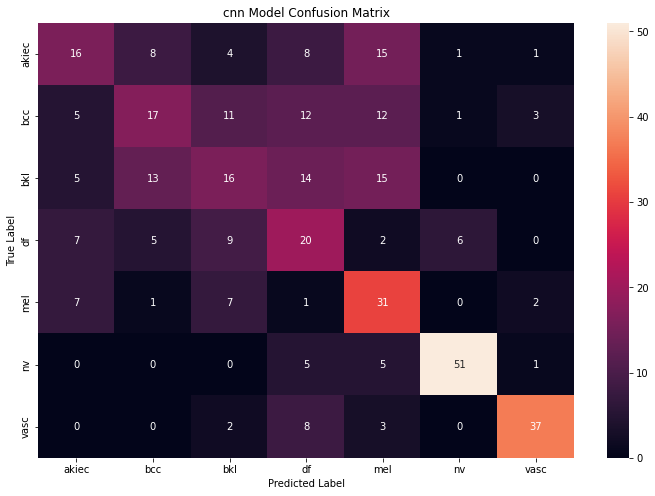

In [ ]:
# Your code here!
plot_cm('cnn', model_stats(cnn, y_test, cnn.predict(X_test), cnn.predict_proba(X_test)))


It looks like our custom CNN's performance is better than the Logistic Regression, KNN, and Decision Tree models. More training epochs or a bigger dataset would probably help with the performance.

Try building your own CNN! Let's see who can get the best performance in your group!

### First, define your model here!

In [ ]:
def CNNClassifier_Modified(epochs=20, batch_size=10, layers=5, dropout=0.5, activation='relu'):
  def set_params():
    i = 1  
  def create_model():
    model = Sequential()
    
    # Your Code Here
    for i in range(layers):
      model.add(Conv2D(128, (3, 3), padding='same'))
      model.add(Activation(activation))
    
    model.add(Flatten())
    model.add(Dense(7))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    # opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  # optimizer=opt,
                  metrics=[tf.keras.metrics.AUC()])
    return model
  return KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=1)

### Then, run the code below to train your model.

In [ ]:
cnn = CNNClassifier_Modified()

cnn.fit(X_train.astype(np.float32), y_train_onehot.astype(np.float32),
        validation_data=(X_test.astype(np.float32),y_test_onehot.astype(np.float32))
        ,verbose=1)

Epoch 1/20
116/116 [==============================] - 26s 204ms/step - loss: 597.7575 - auc_2: 0.5216 - val_loss: 1.9406 - val_auc_2: 0.5492
Epoch 2/20
116/116 [==============================] - 23s 198ms/step - loss: 3.7701 - auc_2: 0.5386 - val_loss: 1.9389 - val_auc_2: 0.5595
Epoch 3/20
116/116 [==============================] - 23s 198ms/step - loss: 5.8474 - auc_2: 0.5617 - val_loss: 1.8959 - val_auc_2: 0.5760
Epoch 4/20
116/116 [==============================] - 23s 198ms/step - loss: 6.3367 - auc_2: 0.5807 - val_loss: 1.8567 - val_auc_2: 0.6327
Epoch 5/20
116/116 [==============================] - 23s 198ms/step - loss: 3.6675 - auc_2: 0.6234 - val_loss: 1.8418 - val_auc_2: 0.6260
Epoch 6/20
116/116 [==============================] - 23s 197ms/step - loss: 6.1333 - auc_2: 0.6223 - val_loss: 1.8956 - val_auc_2: 0.5798
Epoch 7/20
116/116 [==============================] - 23s 198ms/step - loss: 3.6398 - auc_2: 0.6602 - val_loss: 1.7598 - val_auc_2: 0.6953
Epoch 8/20
116/116 [=====

### Next, let's evaluate your model's performance!

In [ ]:
y_pred = cnn.predict(X_test)
y_pred_proba = cnn.predict_proba(X_test)
cnn_cm = model_stats("CNN",y_test,y_pred,y_pred_proba)

CNN
The accuracy of the model is 0.28941
The ROC AUC Score of the model is 0.70027


### Finally, we can plot our confusion matrix below.

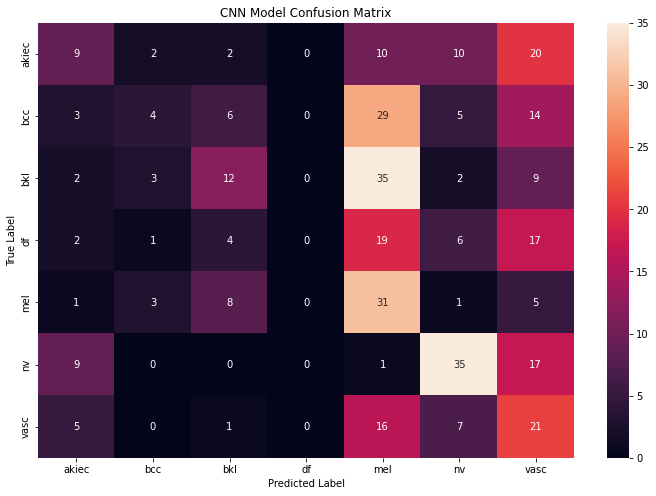

In [ ]:
plot_cm("CNN", cnn_cm)

Let's try using a grid search with our CNN. A note to instructors, this section may take a long time to execute so it's better if students come back to this portion on their own time.

In the variable `param_grid` we can specify which parameters in our CNN we want to modify.

In [ ]:
param_grid = {
              'epochs' :              [10, 20, 30],
              'batch_size' :          [32, 64,128],
              'layers' :              [1, 3, 5],
              'dropout' :             [0.2, 0.3, 0.5],
              'activation' :          ['relu', 'elu']
             }

With this parameter grid we would be training 162 different models! This is because the total number of hyperparameter combinations is calculated as `3 * 3 * 3 * 3 * 2`. For testing out our grid search, let's redefine our parameter grid to just have four possible combinations.



In [ ]:
# Your Code Here





Let's create a validation slice in our dataset.

In [ ]:
X_test_small, X_val, y_test_small, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

Here we've created a class for our Grid Search Classifier that can be used by the hypopt library for generating various models with different hyperparameters.

In [ ]:
#@title Run this to Define our Grid Search CNN Class { display-mode: "form" }
class gridSearchCNN():
    
    keras_model = None
    model = Sequential()
    #epochs=10
    epochs=1
    batch_size=10
    layers=5
    dropout=0.5
    activation='relu'
    
    def __init__(self, **params):
      pass
  
    def fit(self, X, y, sample_weight = None):
        print("fitting")
        self.keras_model.fit(X,y)
        print("fitted")
        return self.keras_model
    def predict(self, X):
        return self.keras_model.predict(X)
    def predict_proba(self, X):
        return self.keras_model.predict_proba(X)
    def score(self, X, y, sample_weight = None):
        print("scoring")
        #return self.keras_model.score(X,y)
        y_pred_proba = self.keras_model.predict_proba(X)
        roc_auc_score_val = roc_auc_score(y, y_pred_proba)
        print("scored")
        return roc_auc_score_val
                
    
    def createKerasCNN(self,):
      
      def create_model():
        self.model = Sequential() 
        
        for i in range(self.layers):
          self.model.add(Conv2D(64, (3, 3), padding='same'))
          self.model.add(Activation(self.activation))
        
        self.model.add(Conv2D(64, (3, 3)))
        self.model.add(Activation(self.activation))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(self.dropout / 2.0))

        self.model.add(Conv2D(128, (3, 3), padding='same'))
        self.model.add(Activation(self.activation))
        self.model.add(Conv2D(128, (3, 3)))
        self.model.add(Activation(self.activation))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(self.dropout / 2.0))

        self.model.add(Flatten())
        self.model.add(Dense(512))
        self.model.add(Activation(self.activation))
        self.model.add(Dropout(self.dropout))
        self.model.add(Dense(7))
        self.model.add(Activation('softmax'))

        # initiate RMSprop optimizer
        opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

        # Let's train the model using RMSprop
        self.model.compile(loss='categorical_crossentropy',
                      optimizer=opt,
                      metrics=[tf.keras.metrics.AUC()])
        return self.model

      return KerasClassifier(build_fn=create_model, epochs=self.epochs, 
                            batch_size=self.batch_size, verbose=2)

    def get_params(self, deep = True):
        return {
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'layers': self.layers,
            'dropout': self.dropout,
            'activation': self.activation
            }

    def set_params(self, **params):
      if 'epochs' in params.keys():
        self.epochs = params['epochs']
      if 'batch_size' in params.keys():
        self.batch_size = params['batch_size']
      if 'layers' in params.keys():
        self.layers = params['layers']
      if 'dropout' in params.keys():
        self.dropout = params['dropout']
      if 'activation' in params.keys():
        self.activation = params['activation']
      
      self.keras_model = self.createKerasCNN()
      return self

Now let's implement our grid search to identify our optimal model parameters.

**Note:** This may take very long to run (around 11 minutes), so it might be a good idea to come back to this later.

In [ ]:
gs = GridSearch(model=gridSearchCNN(),param_grid=param_grid,parallelize=False)
# Your Code Here

# End Code
y_train_onehot = np.zeros((y_train.size, y_train.max().astype(int)+1))
y_train_onehot[np.arange(y_train.size),y_train.astype(int)] = 1

y_val_onehot = np.zeros((y_val.size, y_val.max().astype(int)+1))
y_val_onehot[np.arange(y_val.size),y_val.astype(int)] = 1

Let's evaluate our model with our testing dataset.

In [ ]:
# Your Code Here




Let's also plot the confusion matrix.

In [ ]:
# Your Code Here


#Transfer Learning

Now, let's try implementing *transfer learning.* This a form of machine learning where we take an existing pre-trained network and modify the weights for the top level neurons by training on our dataset. Here, we'll use the MobileNet model as a basis for our model.

In [ ]:
def transfer_learning_model():
  mobilenet_model = MobileNet(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), include_top=False, pooling="max")

  transfer_model = Sequential()
  transfer_model.add(mobilenet_model)
  transfer_model.add(Dropout(0.1))
  transfer_model.add(BatchNormalization())
  transfer_model.add(Dense(256, activation="relu"))
  transfer_model.add(Dropout(0.1))
  transfer_model.add(BatchNormalization())
  transfer_model.add(Dense(7, activation="softmax"))

  # initiate RMSprop optimizer
  #opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

  # Let's train the model using RMSprop
  transfer_model.compile(loss='categorical_crossentropy',
                #optimizer=opt,
                metrics=[tf.keras.metrics.AUC()])

  return transfer_model

We no longer need the validation dataset as we aren't tweaking any hyperparameters anymore, so we can use our original, bigger `X_test` dataset that includes the validation data.

Let's confirm that our training and testing variables are the right shapes. Once again, we'll use the one-hot encoded variables for the output: `y_test_roc` and `y_train_roc`.

Let's define our `transfer_model` and train it below!

In [ ]:
transfer_model = KerasClassifier(build_fn=transfer_learning_model, verbose=1, epochs=20)
# Your Code Here
transfer_model.fit(X_train.astype(np.float32), y_train_onehot.astype(np.float32),
        validation_data=(X_test.astype(np.float32),y_test_onehot.astype(np.float32))
        ,verbose=1)

Epoch 1/20
37/37 [==============================] - 40s 119ms/step - loss: 1.4619 - auc: 0.8561 - val_loss: 8.0373 - val_auc: 0.5436
Epoch 2/20
37/37 [==============================] - 3s 73ms/step - loss: 0.7485 - auc: 0.9533 - val_loss: 7.6910 - val_auc: 0.5981
Epoch 3/20
37/37 [==============================] - 3s 72ms/step - loss: 0.6105 - auc: 0.9674 - val_loss: 2.6290 - val_auc: 0.7793
Epoch 4/20
37/37 [==============================] - 3s 72ms/step - loss: 0.4132 - auc: 0.9824 - val_loss: 5.2916 - val_auc: 0.6957
Epoch 5/20
37/37 [==============================] - 3s 73ms/step - loss: 0.4326 - auc: 0.9800 - val_loss: 3.2762 - val_auc: 0.7898
Epoch 6/20
37/37 [==============================] - 3s 72ms/step - loss: 0.3096 - auc: 0.9890 - val_loss: 5.0219 - val_auc: 0.6910
Epoch 7/20
37/37 [==============================] - 3s 72ms/step - loss: 0.2617 - auc: 0.9914 - val_loss: 3.3516 - val_auc: 0.8001
Epoch 8/20
37/37 [==============================] - 3s 73ms/step - loss: 0.2947 -

Let's also observe its performance:

In [ ]:
# Your Code Here
y_pred = transfer_model.predict(X_test)
y_pred_proba = transfer_model.predict_proba(X_test)
transfer_cm = model_stats("Transfer CNN", y_test, y_pred, y_pred_proba)


Transfer CNN
The accuracy of the model is 0.65633
The ROC AUC Score of the model is 0.92512


Let's take a look at the confusion matrix.

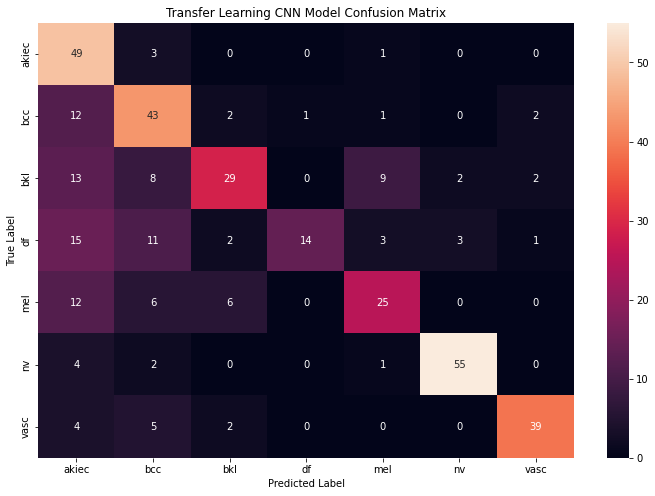

In [ ]:
# Your Code Here
plot_cm("Transfer Learning CNN", transfer_cm)

Great, looks like this model performed the best! **Question:** Why would that be? 

In [ ]:
# Your Response Here




Now that we've created our model, let's save it to a file we can load up later.

In [ ]:
tfjs.converters.save_keras_model(transfer_model.model, 'transfer_model')

 Now, the model should be saved to your computer through your browser. Unfortunately, tensorflowjs doesn't support this version of MobileNet, so we'll have to use our first CNN model for the website deployment.

Great work! We've just developed various ML models to perform classification on our skin lesion dataset! Now, our next step is to package this model into a mobile application. Run the code cell below.

In [ ]:
!zip -r ./cnn_model.zip ./cnn_model/

  adding: cnn_model/ (stored 0%)
  adding: cnn_model/group1-shard6of25.bin (deflated 7%)
  adding: cnn_model/group1-shard7of25.bin (deflated 7%)
  adding: cnn_model/group1-shard14of25.bin (deflated 7%)
  adding: cnn_model/group1-shard2of25.bin (deflated 7%)
  adding: cnn_model/group1-shard3of25.bin (deflated 7%)
  adding: cnn_model/group1-shard4of25.bin (deflated 7%)
  adding: cnn_model/group1-shard24of25.bin (deflated 7%)
  adding: cnn_model/group1-shard8of25.bin (deflated 7%)
  adding: cnn_model/group1-shard10of25.bin (deflated 7%)
  adding: cnn_model/group1-shard23of25.bin (deflated 7%)
  adding: cnn_model/group1-shard19of25.bin (deflated 7%)
  adding: cnn_model/model.json (deflated 89%)
  adding: cnn_model/group1-shard5of25.bin (deflated 7%)
  adding: cnn_model/group1-shard17of25.bin (deflated 7%)
  adding: cnn_model/group1-shard25of25.bin (deflated 7%)
  adding: cnn_model/group1-shard11of25.bin (deflated 7%)
  adding: cnn_model/group1-shard12of25.bin (deflated 7%)
  adding: cnn_mo

After the line of code above finishes executing, click on the folder icon on the left, click the three dots to the left of ```cnn_model.zip```, and download it to your computer. Downloading might take a while! You'll be uploading this file to colab notebook 2b so that you can deploy our first CNN model!